In [1]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

from plotly.subplots import make_subplots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
data_assets = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/asset_details.csv")
data_train = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/train.csv")

In [3]:
data_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [4]:
data_assets.Asset_Name.unique()

array(['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO',
       'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON',
       'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin'], dtype=object)

In [5]:
data_assets.columns

Index(['Asset_ID', 'Weight', 'Asset_Name'], dtype='object')

In [6]:
pd.to_datetime(data_train['timestamp'], unit='s')

0          2018-01-01 00:01:00
1          2018-01-01 00:01:00
2          2018-01-01 00:01:00
3          2018-01-01 00:01:00
4          2018-01-01 00:01:00
                   ...        
24236801   2021-09-21 00:00:00
24236802   2021-09-21 00:00:00
24236803   2021-09-21 00:00:00
24236804   2021-09-21 00:00:00
24236805   2021-09-21 00:00:00
Name: timestamp, Length: 24236806, dtype: datetime64[ns]

## Data preprocessing

In [7]:
rename_dict = {}
asset_details = data_assets 
for a in asset_details['Asset_ID']:
    rename_dict[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

display(rename_dict)

{2: 'Bitcoin Cash',
 0: 'Binance Coin',
 1: 'Bitcoin',
 5: 'EOS.IO',
 7: 'Ethereum Classic',
 6: 'Ethereum',
 9: 'Litecoin',
 11: 'Monero',
 13: 'TRON',
 12: 'Stellar',
 3: 'Cardano',
 8: 'IOTA',
 10: 'Maker',
 4: 'Dogecoin'}

In [8]:
train  = data_train.copy()
train['timestamp'] = train['timestamp'].astype('datetime64[s]')

train_daily = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    train_single = train[train.Asset_ID == asset_id].copy()

    train_single_new = train_single[['timestamp','Count']].resample('D', on='timestamp').sum()
    train_single_new['Open'] = train_single[['timestamp','Open']].resample('D', on='timestamp').first()['Open']
    train_single_new['High'] = train_single[['timestamp','High']].resample('D', on='timestamp').max()['High']
    train_single_new['Low'] = train_single[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    train_single_new['Close'] = train_single[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    train_single_new['Volume'] = train_single[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    
    train_single_new['Asset_ID'] = asset_id

    train_daily = train_daily.append(train_single_new.reset_index(drop=False))
train_daily = train_daily.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

train_daily = train_daily.pivot(index='timestamp', columns='Asset_ID')[['Count', 'Open', 'High', 'Low', 'Close', 'Volume']]
train_daily = train_daily.reset_index(drop=False)

display(train_daily.head(10))

timestamp    Count                                                 \
Asset_ID                   0         1         2   3   4        5         6   
0        2018-01-01  18200.0  365257.0   59257.0 NaN NaN  13640.0  178492.0   
1        2018-01-02  29923.0  574564.0  114865.0 NaN NaN  26127.0  405855.0   
2        2018-01-03  24572.0  518239.0  104420.0 NaN NaN  25961.0  335488.0   
3        2018-01-04  26176.0  565945.0  100805.0 NaN NaN  46104.0  363372.0   
4        2018-01-05  44906.0  595440.0  114272.0 NaN NaN  24917.0  369258.0   
5        2018-01-06  59765.0  468565.0  174319.0 NaN NaN  23286.0  262719.0   
6        2018-01-07  40098.0  386388.0  181473.0 NaN NaN  31543.0  258599.0   
7        2018-01-08  43734.0  592165.0  125114.0 NaN NaN  38313.0  482598.0   
8        2018-01-09  38047.0  485952.0   93463.0 NaN NaN  18704.0  409380.0   
9        2018-01-10  38643.0  581870.0  186286.0 NaN NaN  43536.0  542941.0   

                       ... Volume                                             \
Asset_ID        7   8  ...      4             5              6             7   
0         35134.0 NaN  ...    NaN  1.727143e+06  273636.342034  1.356834e+06   
1         37735.0 NaN  ...    NaN  4.247391e+06  851993.768803  1.347956e+06   
2         26211.0 NaN  ...    NaN  3.992317e+06  672627.375218  8.025051e+05   
3         42602.0 NaN  ...    NaN  7.353260e+06  746365.623031  1.534093e+06   
4         34991.0 NaN  ...    NaN  4.000892e+06  664130.981783  1.117113e+06   
5         23654.0 NaN  ...    NaN  2.794195e+06  334117.052758  7.472549e+05   
6         27046.0 NaN  ...    NaN  3.437363e+06  444145.331800  8.348099e+05   
7         49444.0 NaN  ...    NaN  4.816981e+06  947577.213517  1.689425e+06   
8         37798.0 NaN  ...    NaN  2.179062e+06  703620.080045  1.158671e+06   
9         48305.0 NaN  ...    NaN  7.940171e+06  921530.910844  1.535149e+06   

                                                       
Asset_ID   8             9  10             11  12  13  
0        NaN  4.789200e+05 NaN   26551.358226 NaN NaN  
1        NaN  1.180048e+06 NaN   68285.512588 NaN NaN  
2        NaN  8.381333e+05 NaN   51792.158923 NaN NaN  
3        NaN  1.067253e+06 NaN   53682.119194 NaN NaN  
4        NaN  1.025174e+06 NaN   57536.338144 NaN NaN  
5        NaN  1.613713e+06 NaN   74664.610358 NaN NaN  
6        NaN  7.363563e+05 NaN   80692.257682 NaN NaN  
7        NaN  1.094919e+06 NaN   69093.408644 NaN NaN  
8        NaN  8.045348e+05 NaN  119475.422889 NaN NaN  
9        NaN  8.696432e+05 NaN   91648.088772 NaN NaN  

[10 rows x 85 columns]

## BIT Visualization

In [9]:
crypto_df = data_train

crypto_df.index = pd.to_datetime(crypto_df.timestamp, unit='s')
btc = crypto_df[crypto_df["Asset_ID"]==1] # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows


import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

## Data Distribution

In [10]:
data = data_train

asset_count= []
for i in range(14):
    count = (data["Asset_ID"]==i).sum()
    asset_count.append(count)
fig = px.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             y = asset_count , 
             color = asset_count ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [11]:
def c_time_sub(asset_id, data=data_train):
    df=data[data["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    df.index = pd.to_datetime(df.index, unit='s')
    return df


btc=c_time_sub(asset_id=1)

eth=c_time_sub(asset_id=6)

ada=c_time_sub(asset_id=3)


## Correlation

Bitcoin Cash
Binance Coin
Bitcoin
EOS.IO
Ethereum Classic
Ethereum
Litecoin
Monero
TRON
Stellar
Cardano
IOTA
Maker
Dogecoin


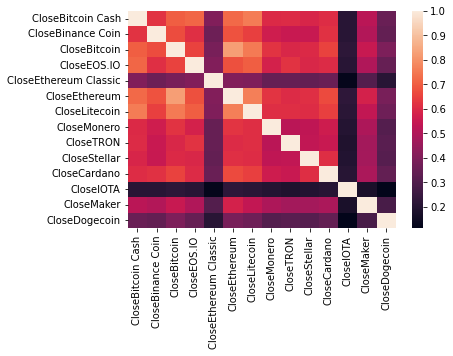

In [12]:
import time

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def plot_corr_2021(ctrain, info):
    totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
    
    crypto_df = data_train
    all_assets_2021 = pd.DataFrame([])
    
    for asset_id, asset_name in rename_dict.items():
        print(asset_name)
        asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
        asset = asset.loc[totimestamp('01/01/2021'):]
        asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
        lret = log_return(asset.Close.fillna(0))[1:]
        
        all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")
    all_assets_2021.rename(columns = {'Close':'CloseBitcoin Cash'}, inplace=True)
    sns.heatmap(all_assets_2021.corr());
    all_assets_2021_corr =  all_assets_2021.corr()
    return all_assets_2021, all_assets_2021_corr
all_assets_2021, all_assets_2021_corr = plot_corr_2021(data_train, data_assets)

In [13]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, ascending=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=ascending)
    return au_corr[0:n]
pd.DataFrame(get_top_abs_correlations(all_assets_2021_corr, n=10, ascending=False), columns=['Correlation'])


Correlation
CloseBitcoin      CloseEthereum     0.935585
CloseEthereum     CloseLitecoin     0.877502
CloseBitcoin Cash CloseLitecoin     0.871917
CloseBitcoin      CloseLitecoin     0.865085
CloseBitcoin Cash CloseEOS.IO       0.820851
                  CloseEthereum     0.818638
CloseEOS.IO       CloseLitecoin     0.795683
CloseBitcoin Cash CloseBitcoin      0.793884
CloseBinance Coin CloseEthereum     0.753743
CloseEOS.IO       CloseEthereum     0.746708

In [14]:
pd.DataFrame(get_top_abs_correlations(all_assets_2021_corr, n=10, ascending=True), columns=['Correlation'])

Correlation
CloseEthereum         CloseDogecoin             0.000567
CloseEthereum Classic CloseCardano              0.001253
                      CloseMonero               0.003740
                      CloseStellar              0.008930
                      CloseTRON                 0.011785
CloseBinance Coin     CloseEthereum Classic     0.020053
CloseLitecoin         CloseDogecoin             0.026424
CloseBitcoin          CloseEthereum Classic     0.032000
                      CloseDogecoin             0.034637
CloseBitcoin Cash     CloseDogecoin             0.042955

## Correlation over time

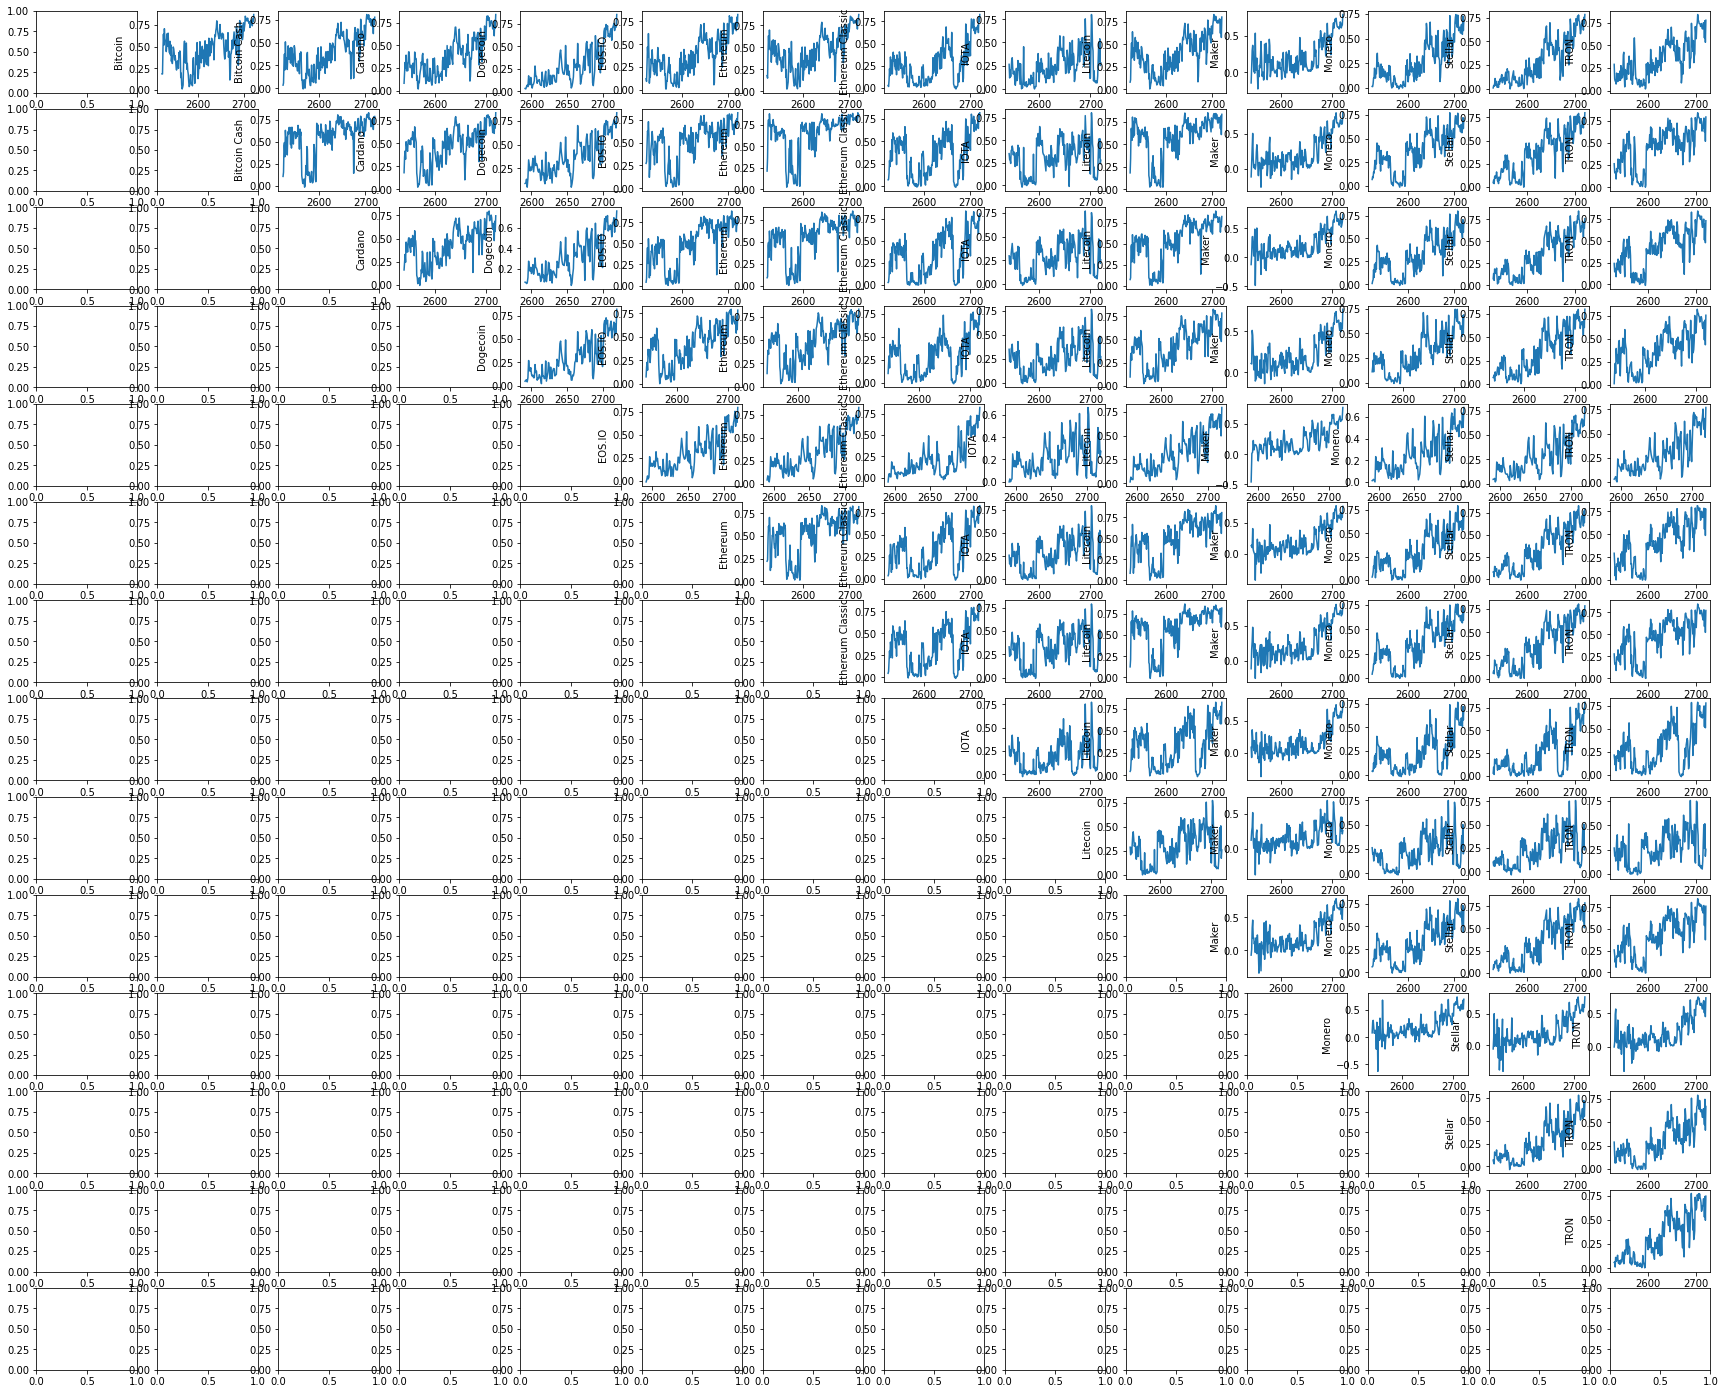

In [15]:
def corr_over_time(crypto_df, asset_id_1 =1, asset_id_2 = 6):
    btc = crypto_df[crypto_df["Asset_ID"]==asset_id_1].set_index("timestamp")
    eth= crypto_df[crypto_df["Asset_ID"]==asset_id_2].set_index("timestamp")

    lret_btc_long = log_return(btc.Close)[1:]
    lret_eth_long = log_return(eth.Close)[1:]
    lret_btc_long.rename('lret_btc', inplace=True)
    lret_eth_long.rename('lret_eth', inplace=True)
    two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

    corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]
    return corr_time

fig, ax = plt.subplots(nrows=14, ncols=14, figsize=(30, 25))
for i in range(0,13):
    for j in range(i+1,14):
        g = sns.lineplot(data = corr_over_time(data_train,asset_id_1 =i, asset_id_2 = j),ax=ax[i,j])
        g.set(xlabel=rename_dict[i], ylabel=rename_dict[j])


## Closing price

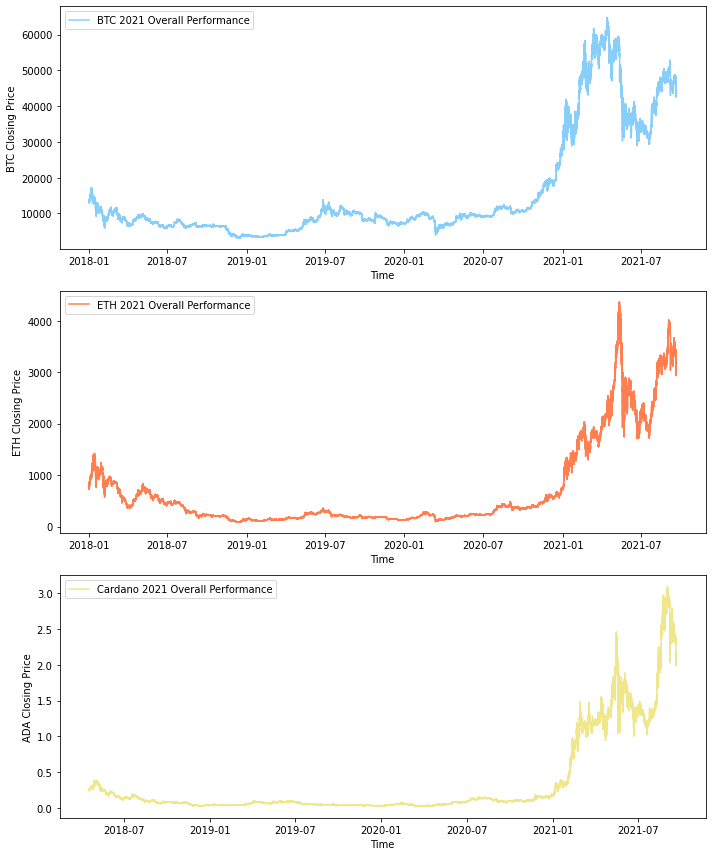

In [16]:
f= plt.figure(figsize=(10,12))  

def gplot(no , data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc, price="Close" , label="BTC 2021 Overall Performance", ylabel="BTC Closing Price", color="Lightskyblue")
gplot(no=312, data=eth, price="Close" ,label="ETH 2021 Overall Performance", ylabel="ETH Closing Price", color="Coral")
gplot(no=313, data=ada, price="Close" ,label="Cardano 2021 Overall Performance", ylabel="ADA Closing Price", color="khaki")

plt.tight_layout()
plt.show()

## Target

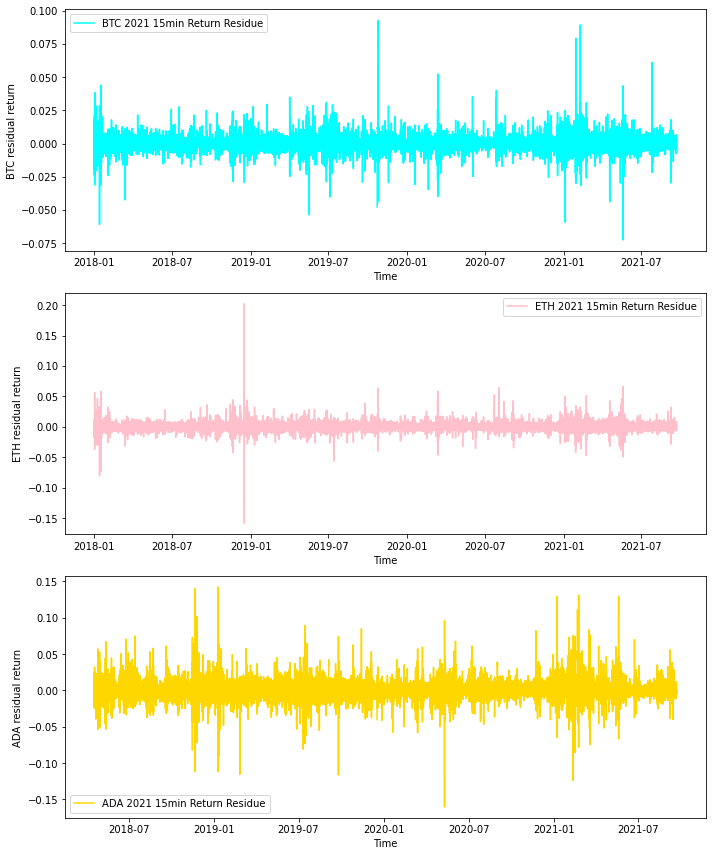

In [17]:
f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc, price="Target" , label="BTC 2021 15min Return Residue", ylabel="BTC residual return", color="Aqua")
gplot(no=312, data=eth, price="Target" ,label="ETH 2021 15min Return Residue", ylabel="ETH residual return", color="Pink")
gplot(no=313, data=ada, price="Target" ,label="ADA 2021 15min Return Residue", ylabel="ADA residual return", color="gold")


plt.tight_layout()
plt.show()

## Candlestick charts

In [18]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(label),
        "y":0.8,
        "x":0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

%matplotlib inline
btc_candle=c_chart(btc[-90:], label="BTC Price")
btc_candle.show()

eth_candle=c_chart(eth[-90:], label="ETH Price ")
eth_candle.show()

## MA

In [19]:

def mov_avg(df, a = 'W',Asset_ID =1, N = 10):
    
    df = df[df.Asset_ID == Asset_ID]
    
    df.set_index(df['timestamp'], inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    df.index = pd.to_datetime(df.index, unit='s')

    #weekly
    convertion={
        'Open':'first',
        'High':'max',
        'Low':'min',
        'Close':'mean',
        'Volume':'sum',    
    }
    ds_df = df.resample(a).apply(convertion)
    
    ds_df['rolling_mean' + str(a) + '_' + str(5)] = ds_df.Close.rolling(window=5).mean()
    ds_df['rolling_mean' + str(a) + '_' + str(10)] = ds_df.Close.rolling(window=10).mean()
    fig = go.Figure(go.Candlestick(x=ds_df.index,open=ds_df['Open'],high=ds_df['High'],low=ds_df['Low'],close=ds_df['Close']))
    fig.update_layout(title='SMA '+str(rename_dict[Asset_ID])+' Close', yaxis_title=str(rename_dict[Asset_ID]))
    fig.update_yaxes(type="log")
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['Close'],mode='lines',name='Close'))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_mean' + str(a) + '_' + str(5)], mode='lines', name='SMA MEAN of 5 ' + str(a),line=dict(color='royalblue', width=2)))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_mean' + str(a) + '_' + str(10)], mode='lines', name='SMA MEAN of 10 ' + str(a), line=dict(color='#555555', width=2)))
    fig.show()
    
    
    #Exp ma
    ewma = pd.Series.ewm
    ds_df['rolling_ema_'+ str(N)]  = ds_df.Close.ewm(min_periods=N, span=N).mean()
    fig = go.Figure(go.Candlestick(x=ds_df.index,open=ds_df['Open'],high=ds_df['High'],low=ds_df['Low'],close=ds_df['Close']))
    fig.update_layout(title='EMA ' +str(rename_dict[Asset_ID])+' Close', yaxis_title=str(rename_dict[Asset_ID]))
    fig.update_yaxes(type="log")
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['Close'],mode='lines',name='Close'))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_ema_' + str(N)], mode='lines', name='EMA MEAN span of '+str(N)+' rolled by '+ str(a),line=dict(color='royalblue', width=2)))
    fig.show()

mov_avg(data_train, Asset_ID =1 )


### Single

In [20]:
mov_avg(data_train, Asset_ID =6 )

## Statistical analysis

In [21]:
import time

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def logret_all_assets(ctrain, info):
    totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
    
    crypto_df = ctrain
    all_assets_2021 = pd.DataFrame([])
    
    for asset_id, asset_name in rename_dict.items():
        asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
        asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
        lret = log_return(asset.Close.fillna(0))[1:]
        
        all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")
    all_assets_2021.rename(columns = {'Close':'Close Bitcoin Cash'}, inplace=True)
    all_assets_2021.index  = pd.to_datetime(all_assets_2021.index, unit='s')
    return all_assets_2021
all_assets = logret_all_assets(data_train, data_assets)

<AxesSubplot:>

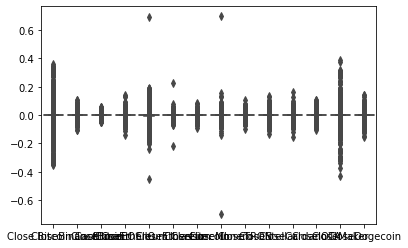

In [22]:
sns.boxplot(data = all_assets)

## Variances

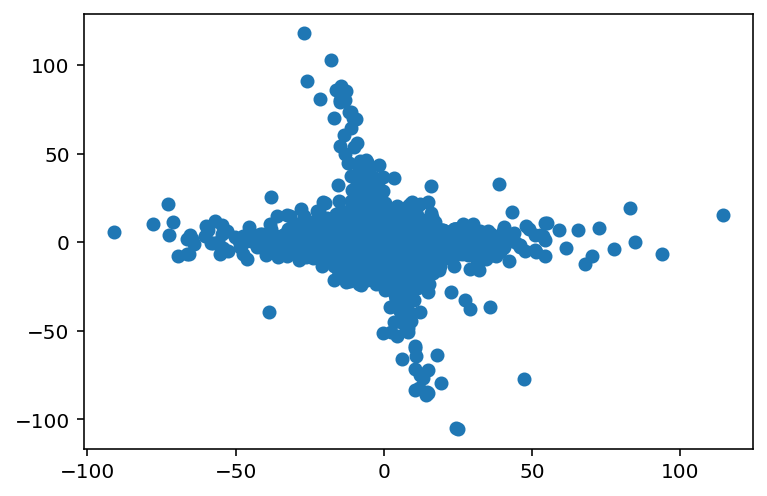

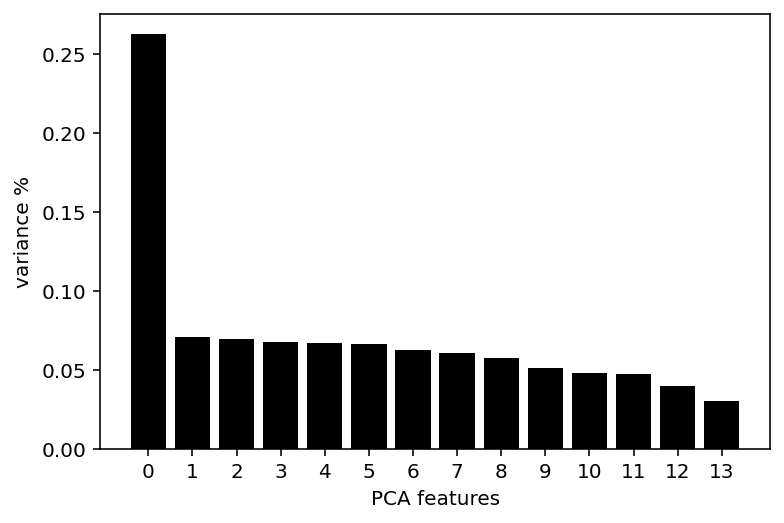

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


def vis_pca(all_assets):
    X_std = StandardScaler().fit_transform(all_assets.fillna(0))
    pca = PCA()
    X_std_pca = pca.fit_transform(X_std)
    plot = plt.scatter(X_std_pca[:,0], X_std_pca[:,1])
    plt.show()

    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()
vis_pca(all_assets)

## Month

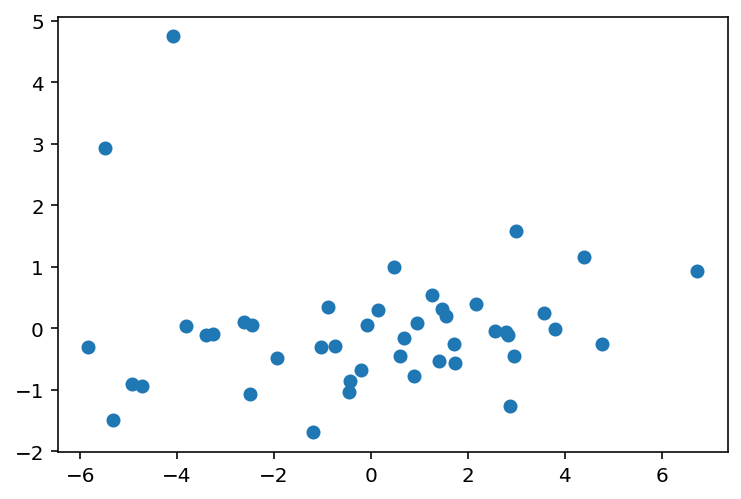

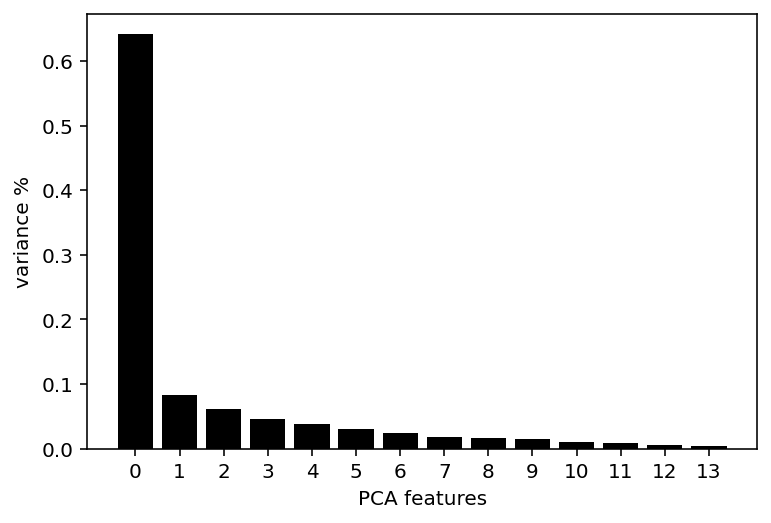

In [24]:
vis_pca(all_assets.resample('M').mean())

## Week

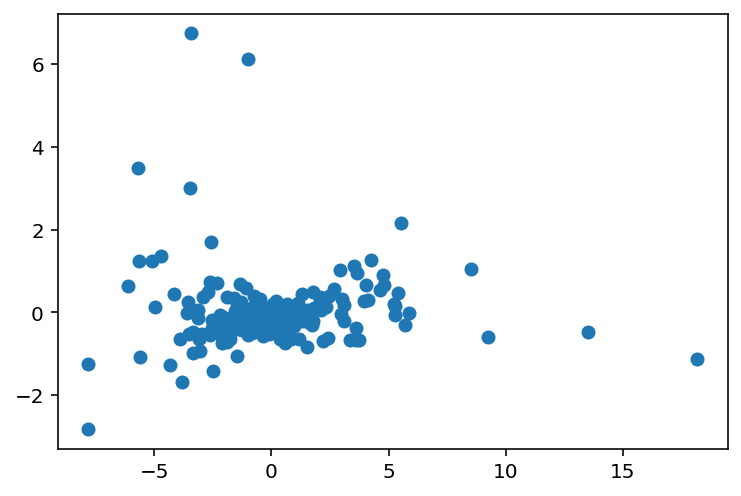

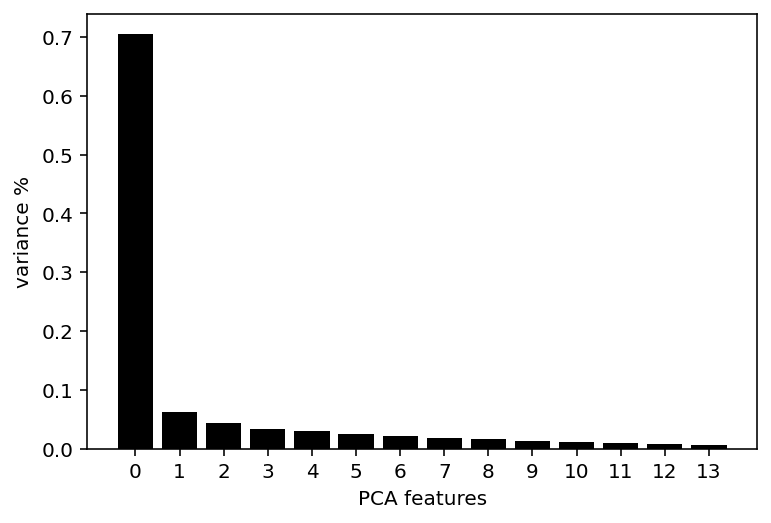

In [25]:
vis_pca(all_assets.resample('W').mean())

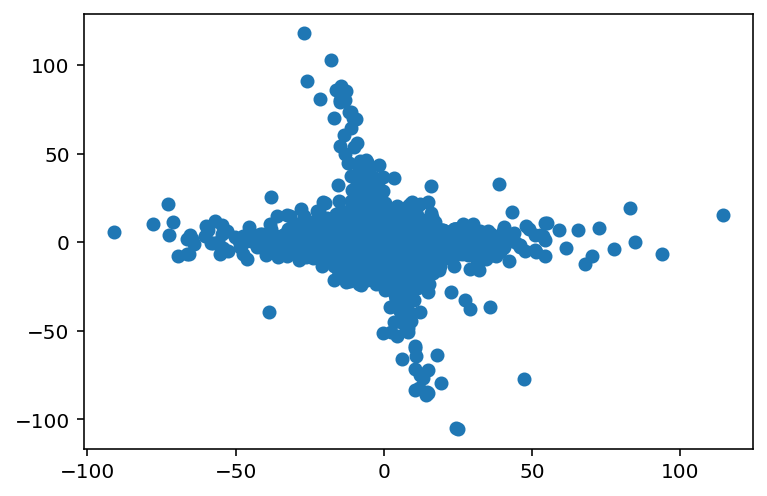

([<matplotlib.axis.XTick at 0x7f170de7bc50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

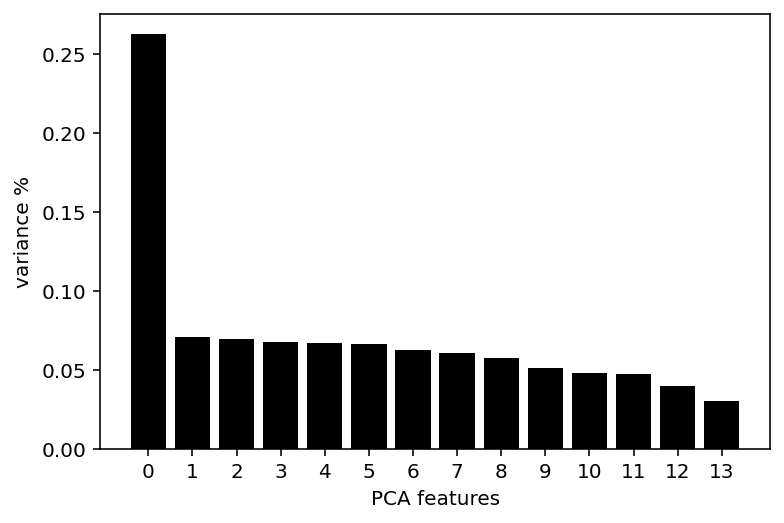

In [26]:
X_std = StandardScaler().fit_transform(all_assets.fillna(0))
pca = PCA()
X_std_pca = pca.fit_transform(X_std)
plot = plt.scatter(X_std_pca[:,0], X_std_pca[:,1])
plt.show()

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Arima

## Seasonal Decomposition

In [27]:
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label, a):
    df=data.resample(a).mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

### Month

BTC Seasonal Decomposition


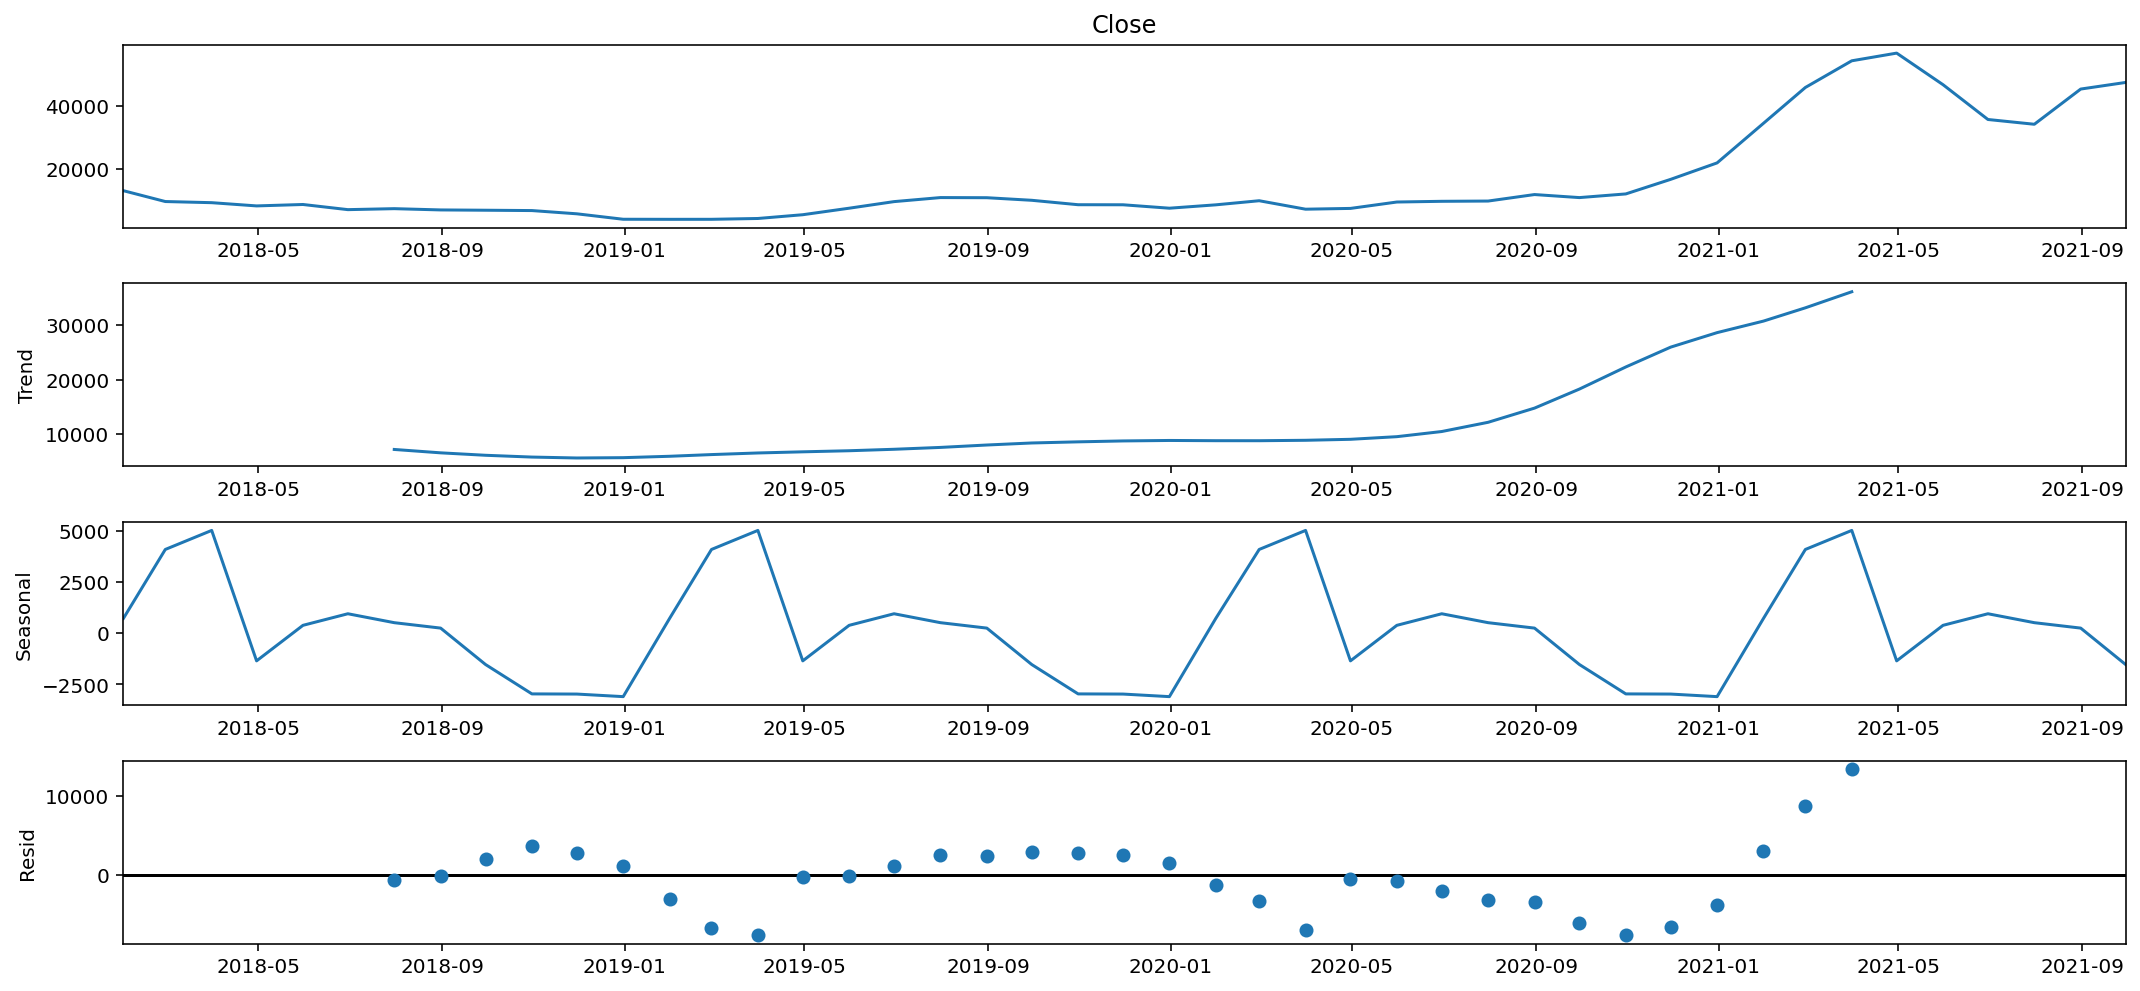

In [28]:
season_df(data=btc, label="BTC Seasonal Decomposition",a ="M")

### Day

BTC Seasonal Decomposition


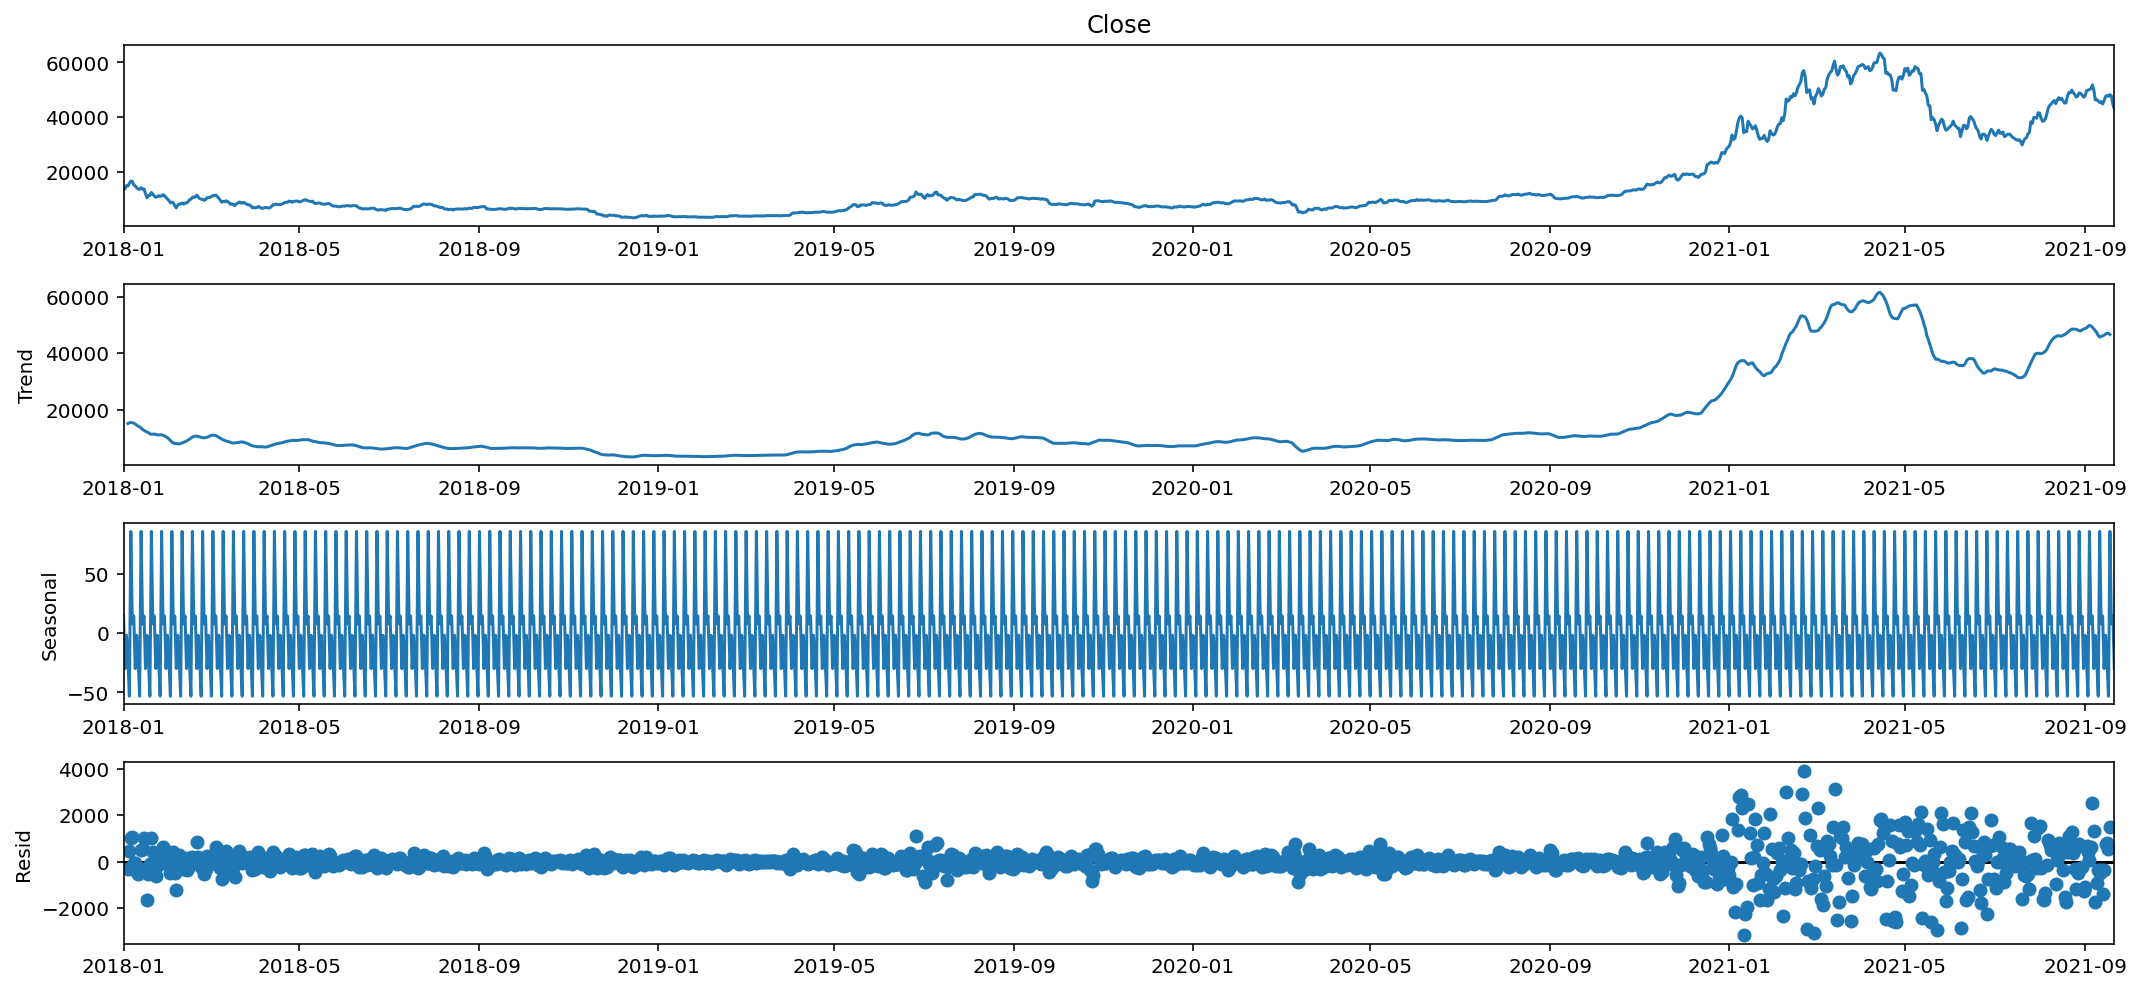

In [29]:
season_df(data=btc, label="BTC Seasonal Decomposition",a ="D")

### Hour

BTC Seasonal Decomposition


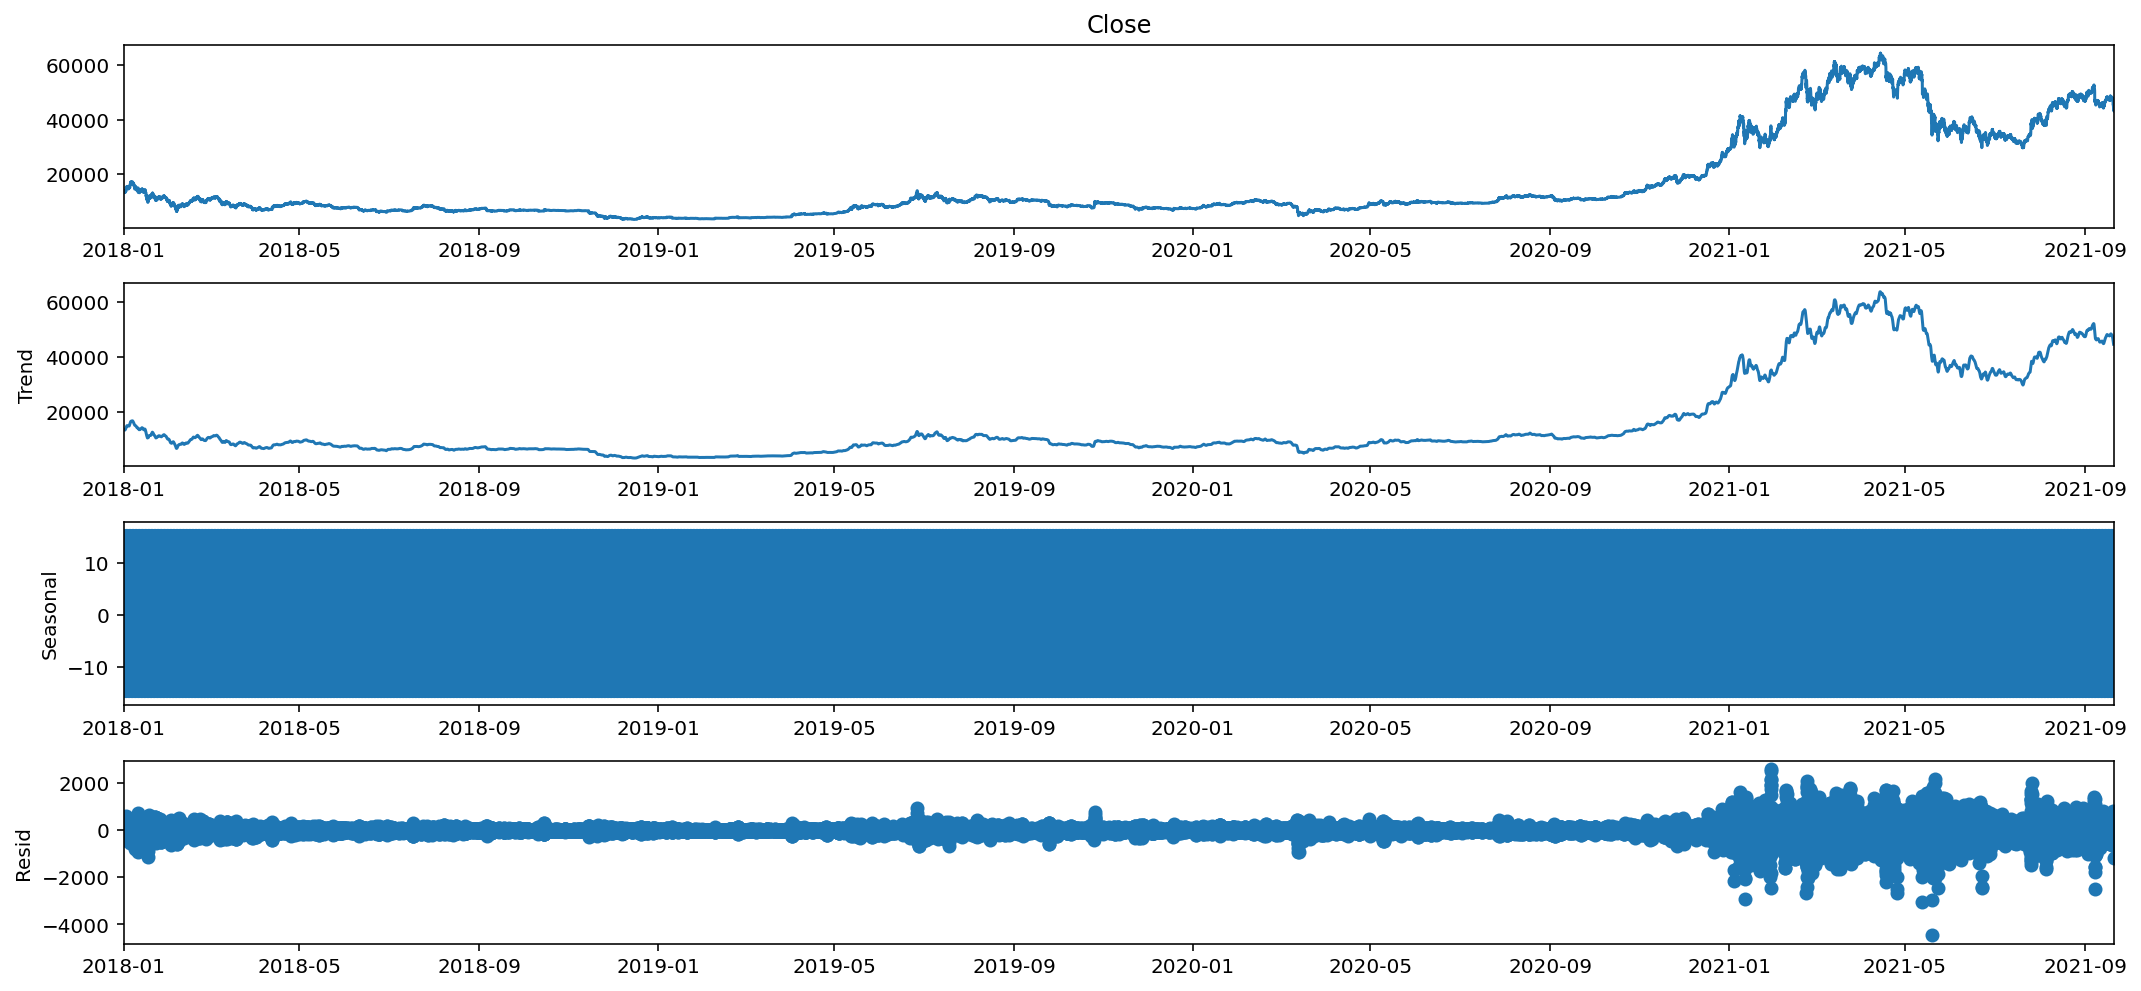

In [30]:
season_df(data=btc, label="BTC Seasonal Decomposition",a ="H")

# Box-Cox Transformation for Arima

In [32]:
#Box-Cox Transformation
btc_month=btc.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.865195


Series is still not stationary =(

# Seasonal differentiation

## 12 Month

In [33]:
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.064412


# 3 month

In [34]:
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.008037


In [35]:
btc_month.box_diff_seasonal_12.head()

timestamp
2018-01-31   NaN
2018-02-28   NaN
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
Freq: M, Name: box_diff_seasonal_12, dtype: float64

## STL-decomposition

Dickey–Fuller test: p=0.020615


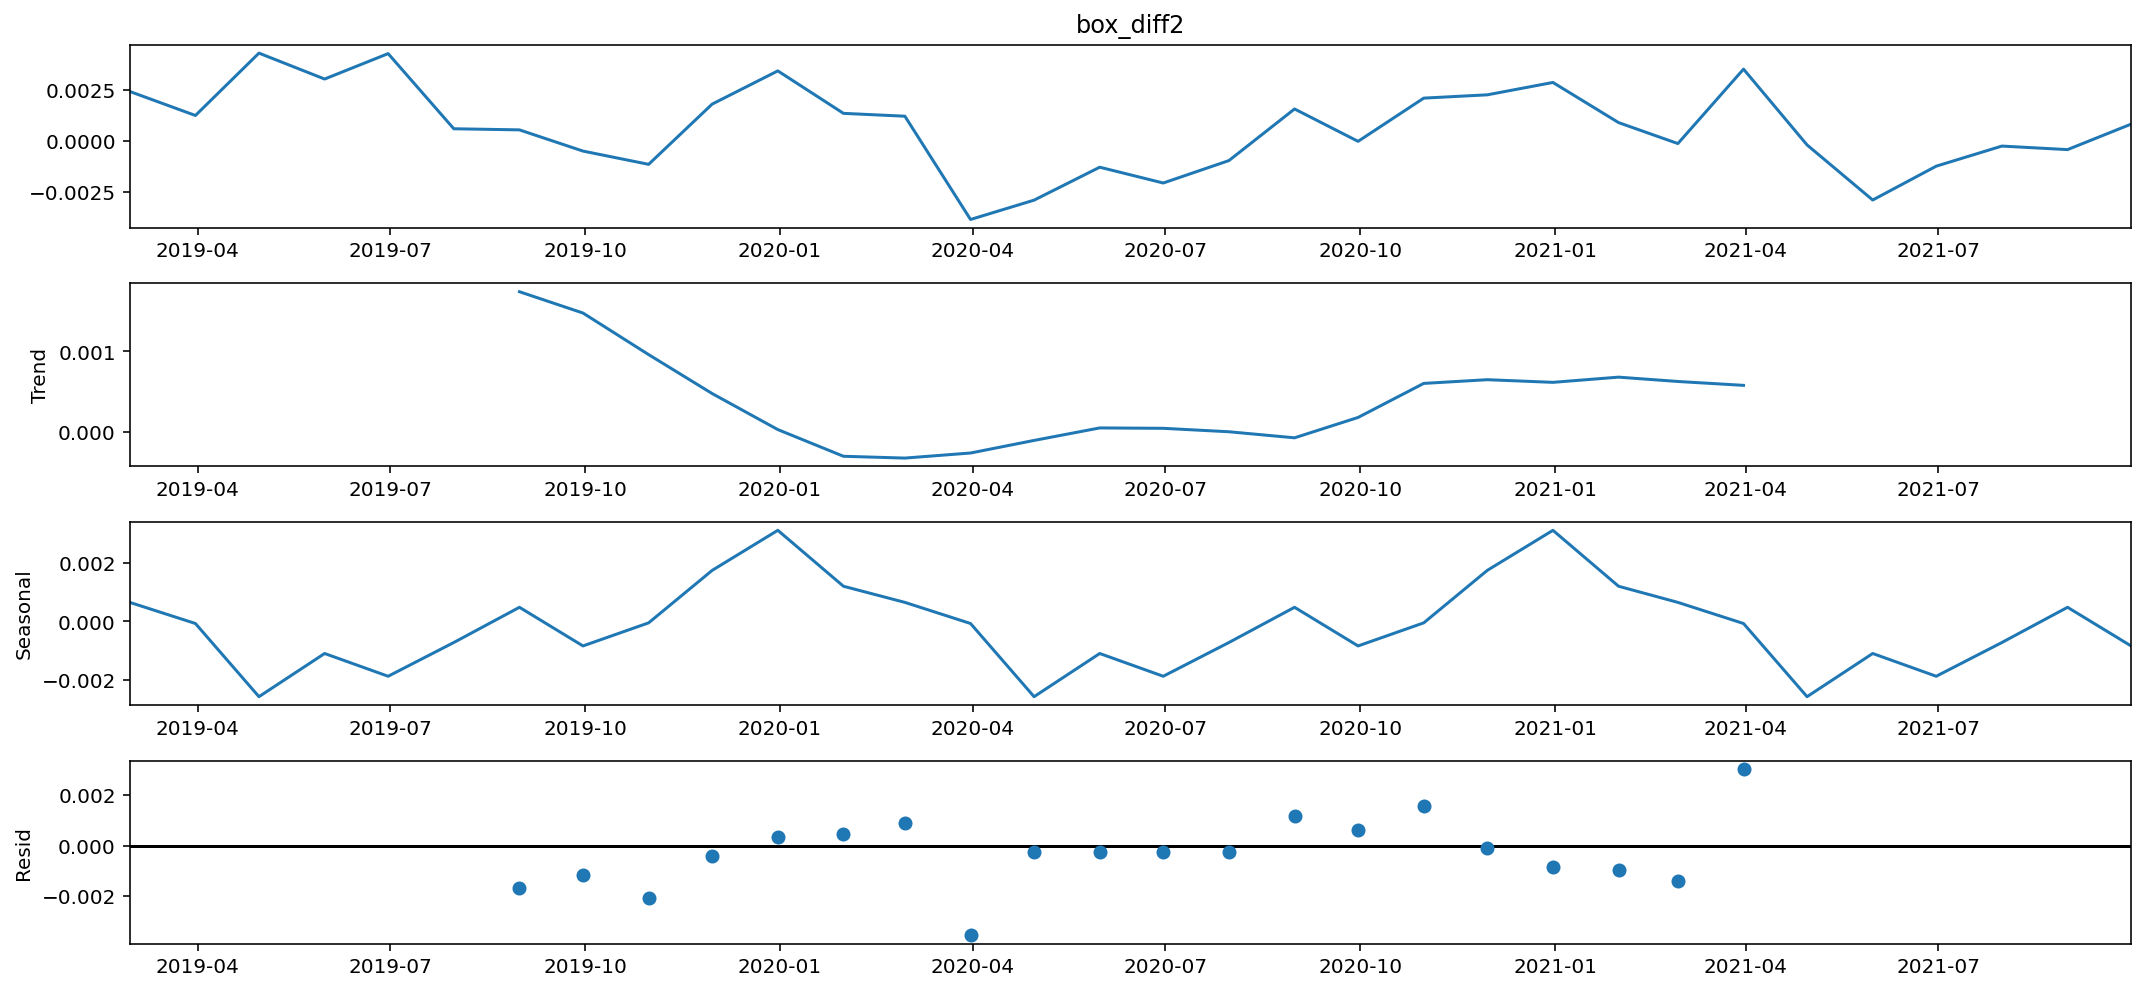

In [36]:
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

# ACF

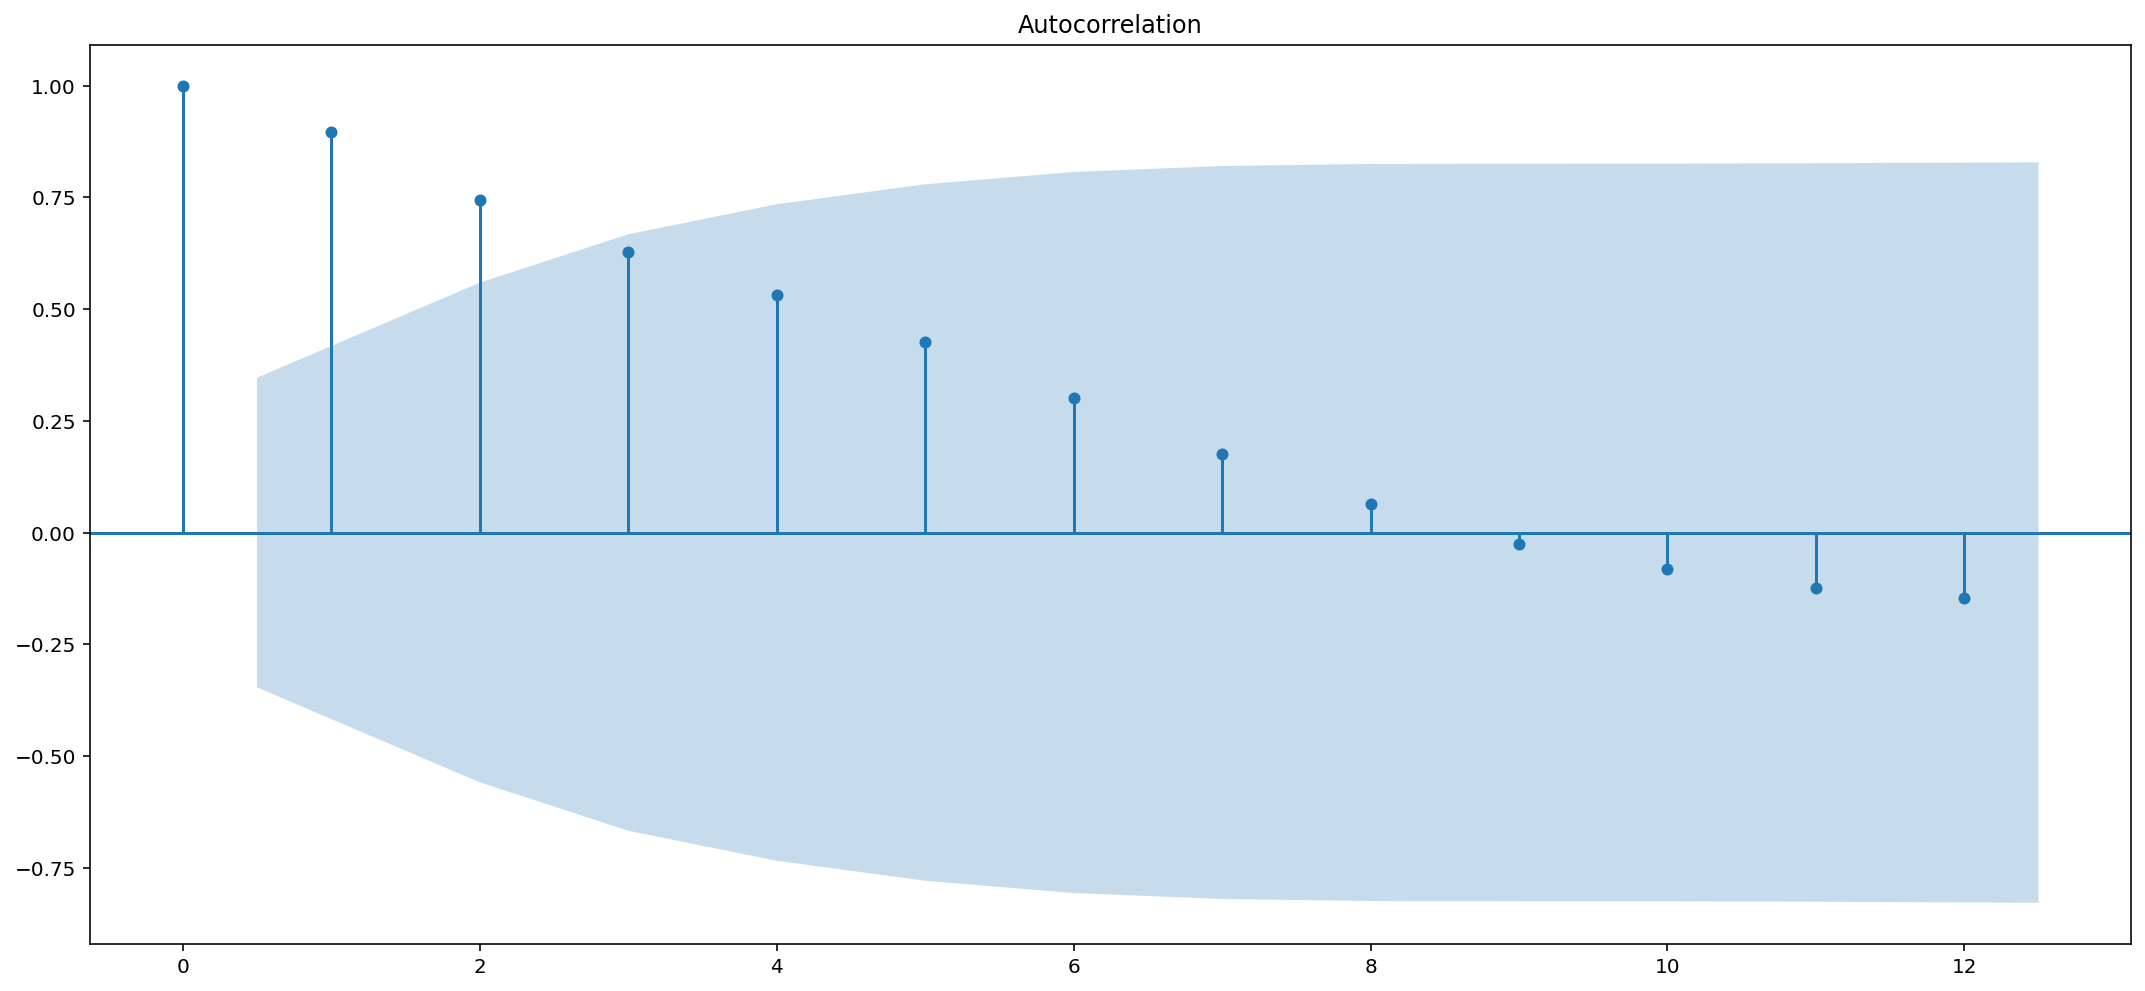

In [37]:
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

# PACF

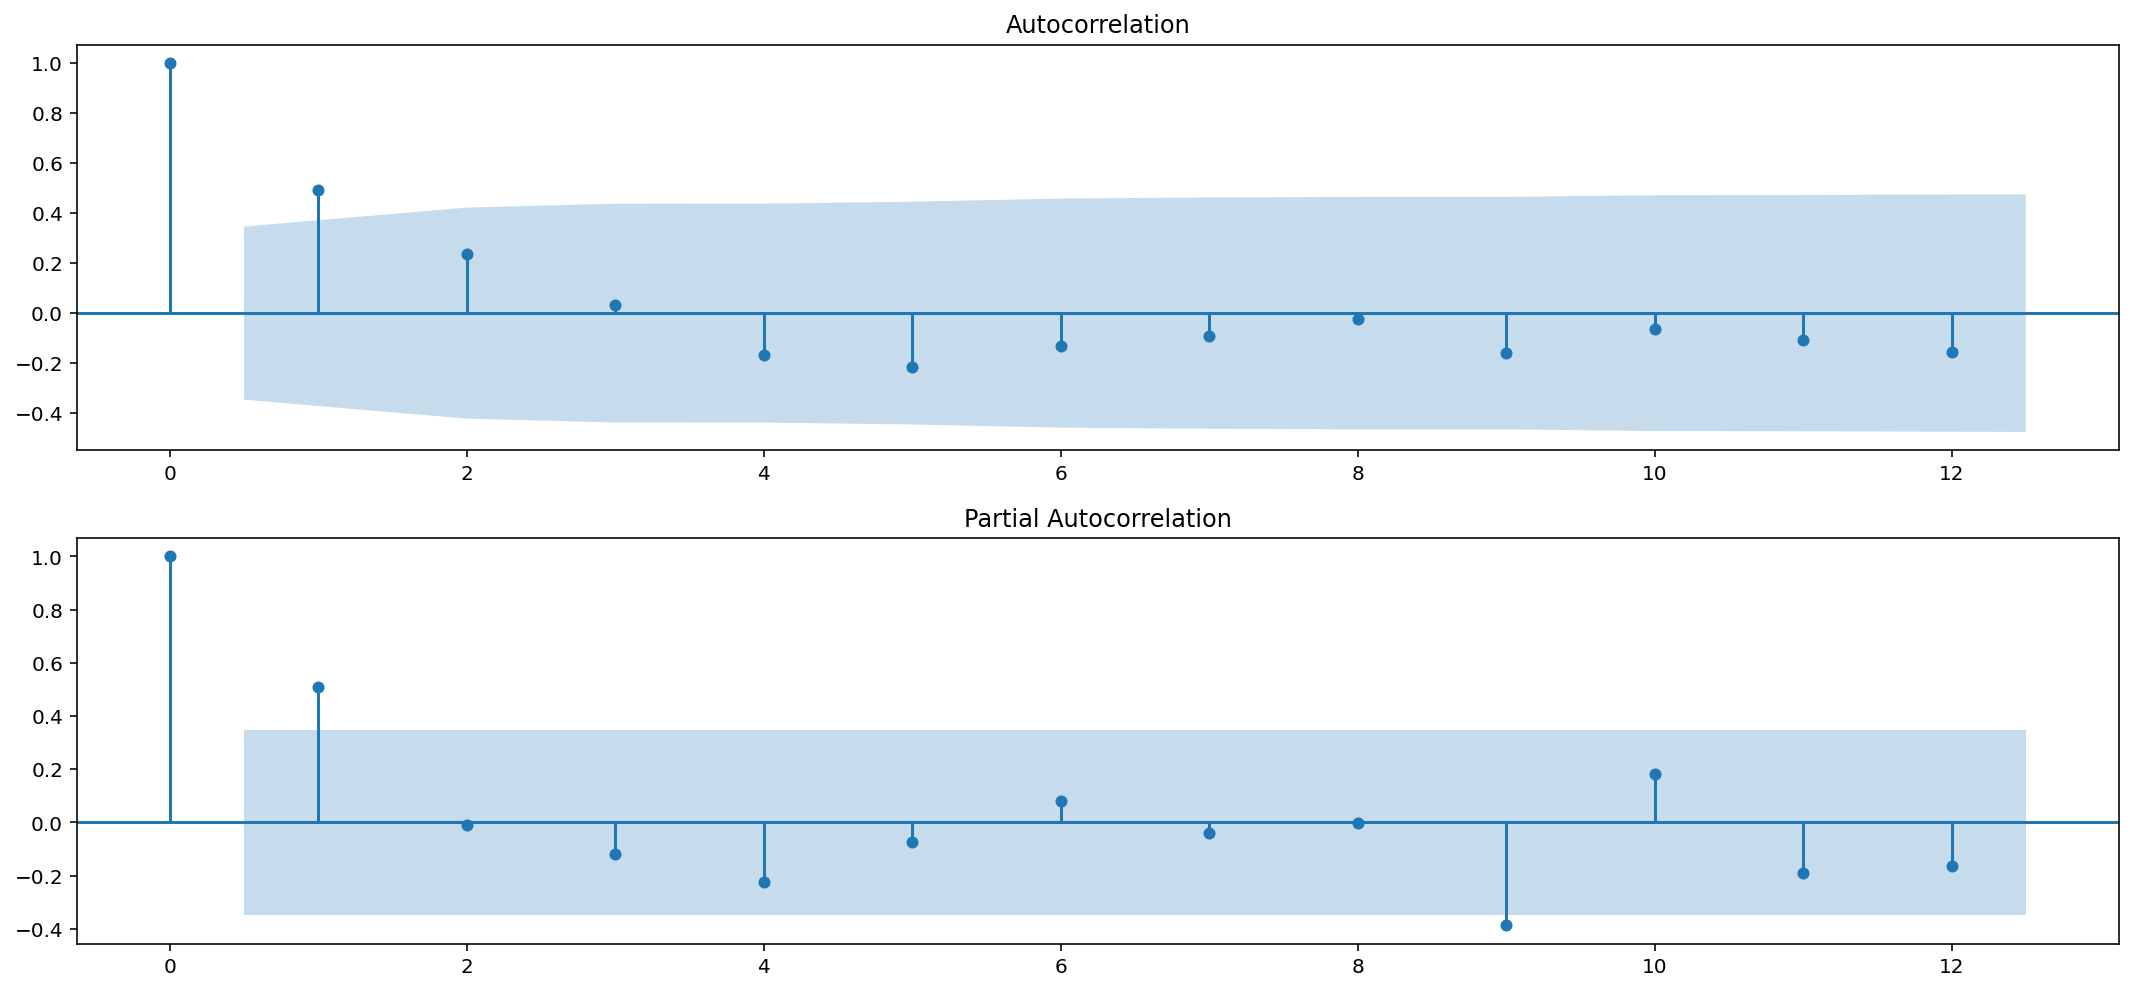

In [38]:
ax = plt.subplot(211)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

# SARIMAX

In [39]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

DEBUG = False

if not DEBUG:
    for param in parameters_list:
        try:
            model = SARIMAX(btc_month['2018-01-31':'2021-05-31'].close_box, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print('bad parameter combination:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())
    print(best_model.summary())
    
    print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

  parameters         aic
3     (1, 0) -402.298027
1     (0, 1) -401.440305
6     (2, 0) -400.372042
4     (1, 1) -400.369709
2     (0, 2) -398.764717
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   41
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 203.149
Date:                Fri, 07 Jan 2022   AIC                           -402.298
Time:                        09:16:57   BIC                           -398.920
Sample:                    01-31-2018   HQIC                          -401.077
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3842      0.143      2.690      0.007      

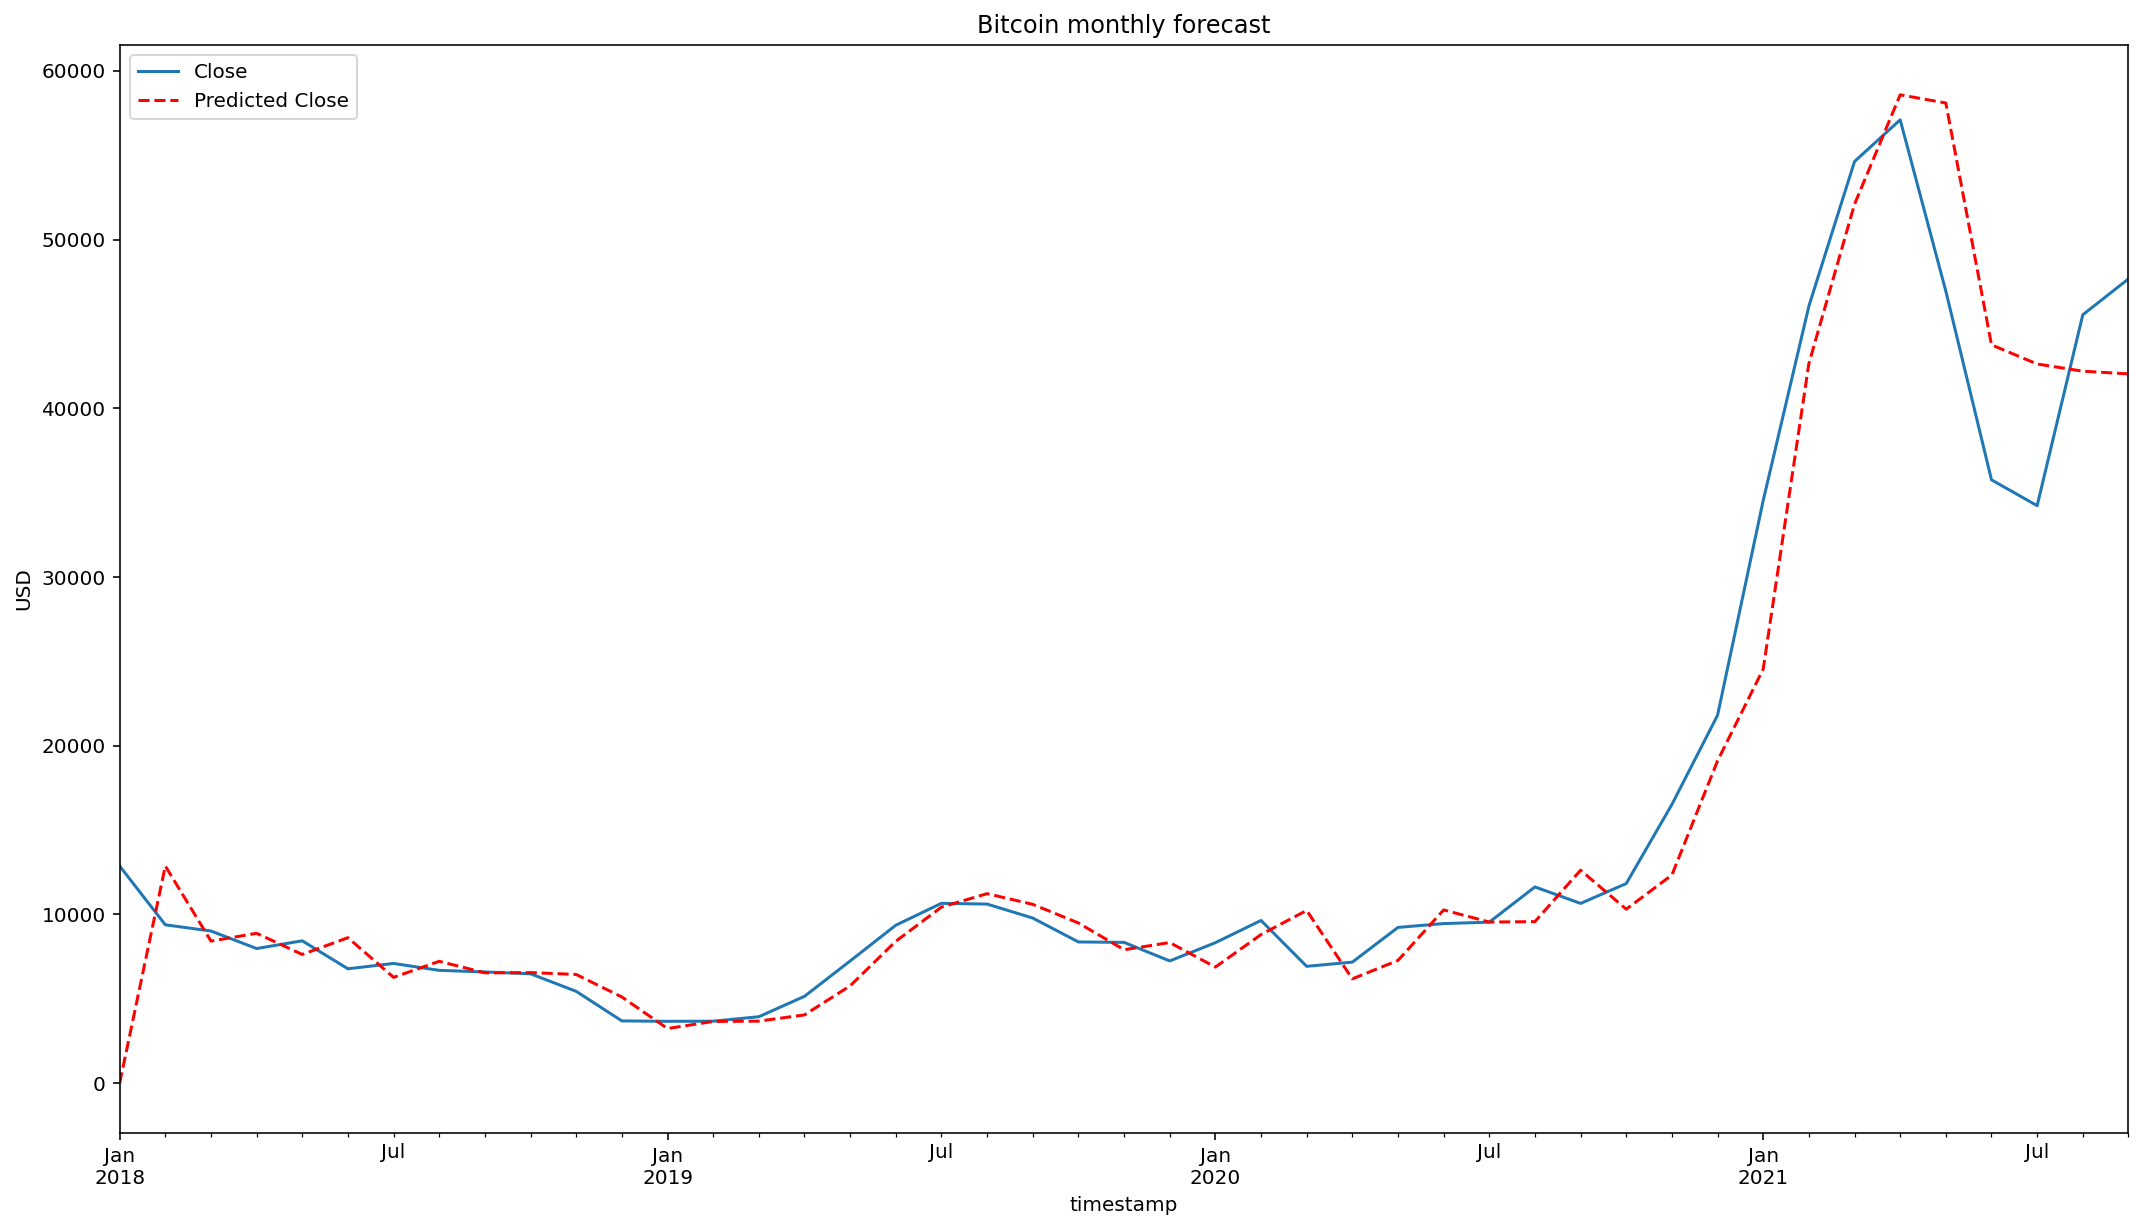

In [41]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
# Prediction
btc_month_pred = btc_month[['Close']]

btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2021, 9, 21)), lmbda)
plt.figure(figsize=(18,10))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()